A vs genre - ARI=0.005, NMI=0.121
A vs rating_cat - ARI=0.018, NMI=0.064
B vs genre - ARI=0.007, NMI=0.154
B vs rating_cat - ARI=0.020, NMI=0.064


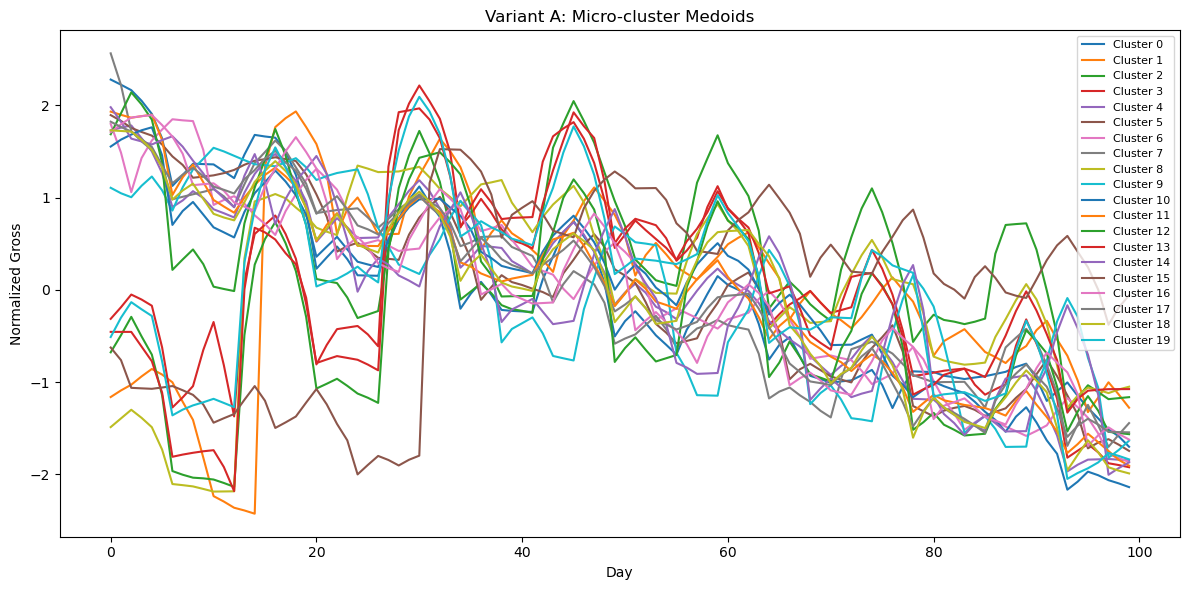

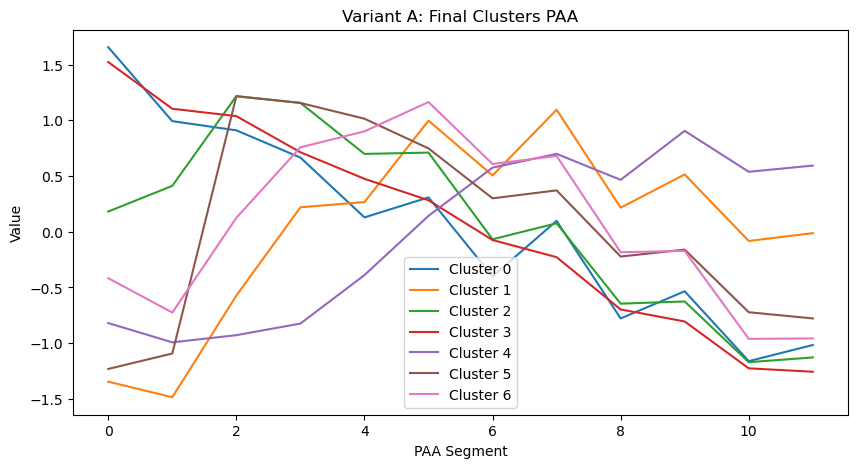

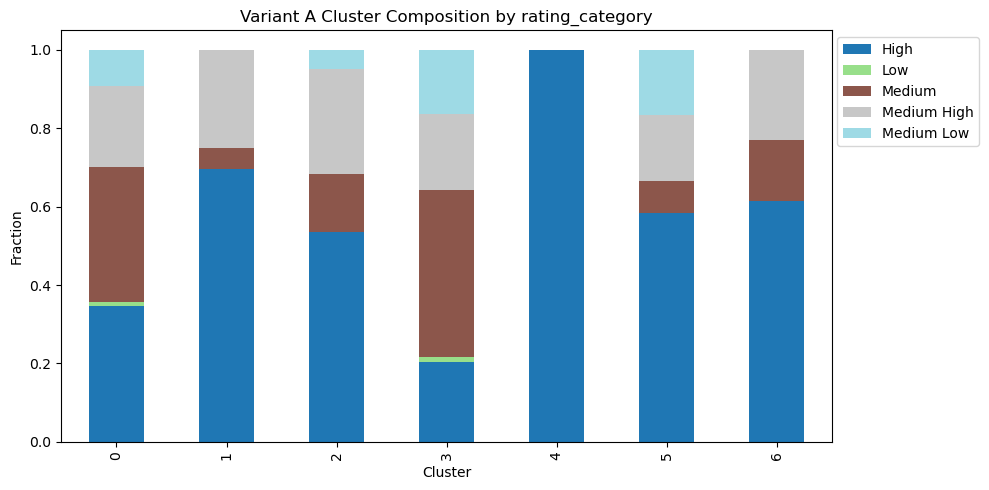

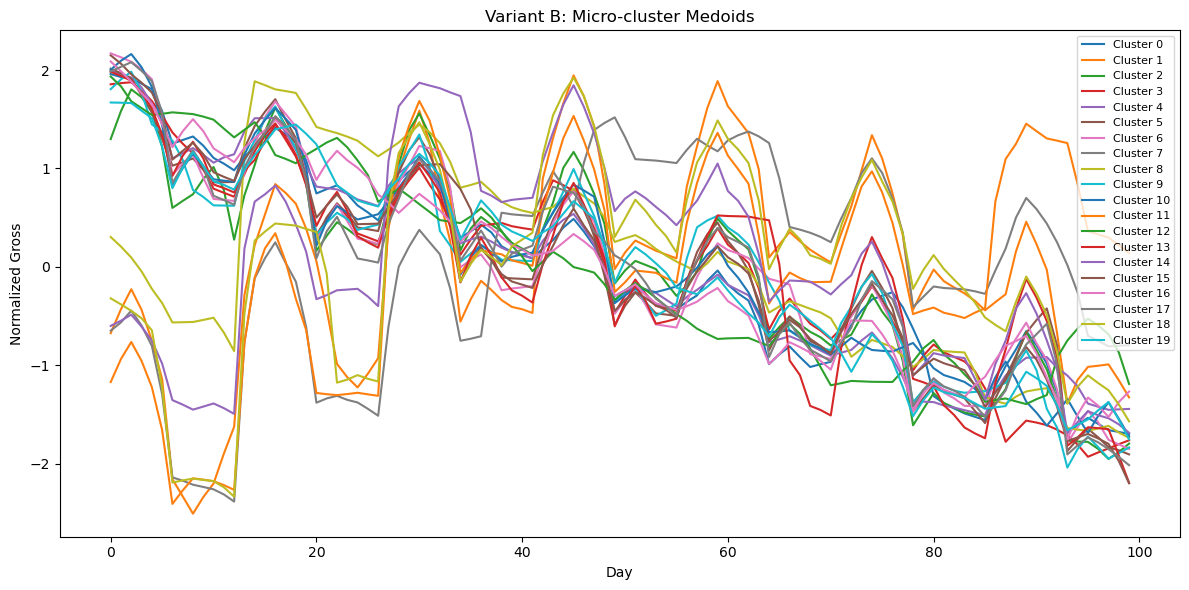

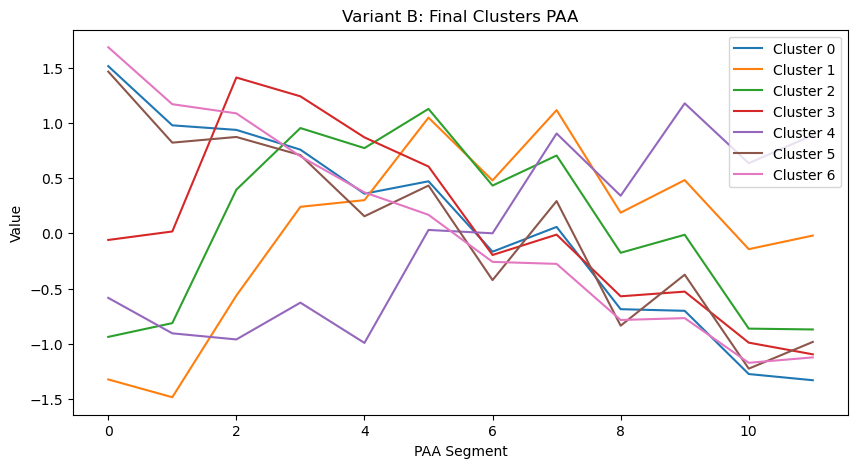

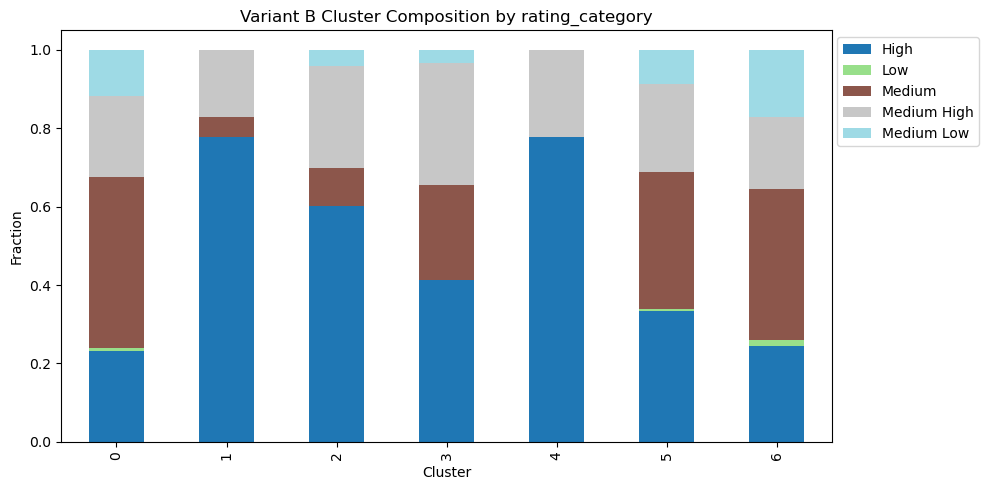

In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans, KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from tslearn.metrics import cdist_dtw
from pycatch22 import catch22_all
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 1. Preprocessing
# -------------------------
def preprocess_series(Y):
    Y_log = np.log1p(Y)
    scaler = StandardScaler()
    Y_z = scaler.fit_transform(Y_log.T).T  # z-score per serie
    return Y_z

# -------------------------
# 2. Feature extraction
# -------------------------
def extract_features_catch22(Y_z):
    feats = []
    names = None
    for ts in Y_z:
        res = catch22_all(ts)
        if names is None:
            names = res['names']
        feats.append(res['values'])
    return pd.DataFrame(feats, columns=names)


def extract_features_interpretable(Y_z, M=12):
    feats = []
    for ts in Y_z:
        peak_day = np.argmax(ts)
        decay = ts[7:14].sum() / (ts[0:7].sum() + 1e-8)
        tail_share = ts[29:100].sum() / (ts.sum() + 1e-8)
        seglen = len(ts) // M
        paa = [ts[i*seglen:(i+1)*seglen].mean() for i in range(M)]
        feats.append([peak_day, decay, tail_share] + paa)
    cols = ["peak_day", "decay", "tail_share"] + [f"PAA{i}" for i in range(M)]
    return pd.DataFrame(feats, columns=cols)

# -------------------------
# 3. Micro-clustering
# -------------------------
def microcluster(features, k=200):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=256)
    labels = kmeans.fit_predict(features)
    return labels

# -------------------------
# 4. Centroid representation (Medoid default)
# -------------------------
def compute_cluster_representatives(Y, labels, method="medoid"):
    reps = []
    cluster_map = {}  # mapping micro-cluster -> index in reps
    for idx_c, c in enumerate(np.unique(labels)):
        idx = np.where(labels == c)[0]
        cluster_ts = Y[idx]
        if method == "mean":
            reps.append(cluster_ts.mean(axis=0))
        elif method == "medoid":
            dist_mat = cdist_dtw(cluster_ts, cluster_ts)
            medoid_idx = np.argmin(dist_mat.sum(axis=1))
            reps.append(cluster_ts[medoid_idx])
        cluster_map[c] = idx_c
    return np.array(reps), cluster_map

# -------------------------
# 5. PAA transform
# -------------------------
def paa_transform(Y, M=12):
    paa_list = []
    for ts in Y:
        seglen = len(ts) // M
        paa = [ts[i*seglen:(i+1)*seglen].mean() for i in range(M)]
        paa_list.append(paa)
    return np.array(paa_list)

# -------------------------
# 6. Final clustering
# -------------------------
def final_clustering(PAA, method="kmeans", k=5):
    if method == "kmeans":
        model = KMeans(n_clusters=k, random_state=0)
        labels = model.fit_predict(PAA)
    elif method == "agglo_dtw":
        D = cdist_dtw(PAA, PAA)
        model = AgglomerativeClustering(n_clusters=k, affinity="precomputed", linkage="average")
        labels = model.fit_predict(D)
    else:
        raise ValueError("method must be 'kmeans' or 'agglo_dtw'")
    return labels

# -------------------------
# 7. Evaluation
# -------------------------
def evaluate(labels, meta, label_col):
    ari = adjusted_rand_score(meta[label_col], labels)
    nmi = normalized_mutual_info_score(meta[label_col], labels)
    return ari, nmi

# -------------------------
# 8. Propagate cluster labels to all series
# -------------------------
def propagate_final_labels(micro_labels, final_labels, cluster_map):
    return np.array([final_labels[cluster_map[micro_labels[i]]] for i in range(len(micro_labels))])

# -------------------------
# 9. Visualization
# -------------------------
def plot_cluster_centroids(reps, micro_labels, title="Cluster Representatives", n_show=20):
    plt.figure(figsize=(12, 6))
    for i, ts in enumerate(reps[:n_show]):
        plt.plot(ts, label=f"Cluster {i}")
    plt.title(title)
    plt.xlabel("Day")
    plt.ylabel("Normalized Gross")
    plt.legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    plt.show()


def plot_paa_clusters(PAA, final_labels, title="Final Clusters (PAA)"):
    df = pd.DataFrame(PAA)
    df['cluster'] = final_labels
    plt.figure(figsize=(10,5))
    for c in sorted(np.unique(final_labels)):
        mean_curve = df[df['cluster']==c].iloc[:, :-1].mean(axis=0)
        plt.plot(range(mean_curve.shape[0]), mean_curve, label=f"Cluster {c}")
    plt.title(title)
    plt.xlabel("PAA Segment")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


def plot_cluster_distribution(final_labels, meta, label_col="rating_category", title="Cluster Distribution"):
    df = pd.DataFrame({"cluster": final_labels, "meta": meta[label_col]})
    cross = pd.crosstab(df['cluster'], df['meta'], normalize='index')
    cross.plot(kind='bar', stacked=True, figsize=(10,5), colormap='tab20')
    plt.title(f"{title} by {label_col}")
    plt.ylabel("Fraction")
    plt.xlabel("Cluster")
    plt.legend(loc='upper right', bbox_to_anchor=(1.2,1))
    plt.tight_layout()
    plt.show()

# -------------------------
# 10. Main Pipeline
# -------------------------
if __name__ == "__main__":
    DATA_PATH = "/Users/chiaraferrara/Desktop/Unipi/Magistrale/DM 2/dm2_project/dm2_dataset_2425_imdb/imdb_ts.csv"
    df = pd.read_csv(DATA_PATH)
    Y = df[[str(i) for i in range(100)]].values
    meta = df[["genre", "rating_category"]]

    # Preprocess
    Y_z = preprocess_series(Y)

    # Variant A: catch22 only
    featsA = extract_features_catch22(Y_z)
    microA = microcluster(featsA, k=200)
    repsA, cluster_map_A = compute_cluster_representatives(Y_z, microA, method="medoid")
    PAA_A = paa_transform(repsA, M=12)
    finalA = final_clustering(PAA_A, method="kmeans", k=7)
    final_labels_A = propagate_final_labels(microA, finalA, cluster_map_A)

    # Variant B: catch22 + interpretabili
    featsB = pd.concat([featsA, extract_features_interpretable(Y_z)], axis=1)
    microB = microcluster(featsB, k=200)
    repsB, cluster_map_B = compute_cluster_representatives(Y_z, microB, method="medoid")
    PAA_B = paa_transform(repsB, M=12)
    finalB = final_clustering(PAA_B, method="kmeans", k=7)
    final_labels_B = propagate_final_labels(microB, finalB, cluster_map_B)

    # Evaluate
    for name, labels in zip(["A", "B"], [final_labels_A, final_labels_B]):
        ari, nmi = evaluate(labels, meta, "genre")
        print(f"{name} vs genre - ARI={ari:.3f}, NMI={nmi:.3f}")
        ari, nmi = evaluate(labels, meta, "rating_category")
        print(f"{name} vs rating_cat - ARI={ari:.3f}, NMI={nmi:.3f}")

    # Visualizations
    plot_cluster_centroids(repsA, microA, title="Variant A: Micro-cluster Medoids")
    plot_paa_clusters(PAA_A, finalA, title="Variant A: Final Clusters PAA")
    plot_cluster_distribution(final_labels_A, meta, label_col="rating_category", title="Variant A Cluster Composition")

    plot_cluster_centroids(repsB, microB, title="Variant B: Micro-cluster Medoids")
    plot_paa_clusters(PAA_B, finalB, title="Variant B: Final Clusters PAA")
    plot_cluster_distribution(final_labels_B, meta, label_col="rating_category", title="Variant B Cluster Composition")


In [28]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def choose_k_elbow_silhouette(PAA, k_min=2, k_max=20):
    wcss = []
    sil_scores = []
    Ks = range(k_min, k_max+1)

    for k in Ks:
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(PAA)
        wcss.append(kmeans.inertia_)  # somma delle distanze al centroide
        sil_scores.append(silhouette_score(PAA, labels))

    # Plot WCSS (Elbow)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(Ks, wcss, 'o-', color='blue')
    plt.xlabel("Number of clusters k")
    plt.ylabel("WCSS")
    plt.title("Elbow Method")

    # Plot Silhouette
    plt.subplot(1,2,2)
    plt.plot(Ks, sil_scores, 'o-', color='green')
    plt.xlabel("Number of clusters k")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score")
    plt.tight_layout()
    plt.show()

    return Ks, wcss, sil_scores


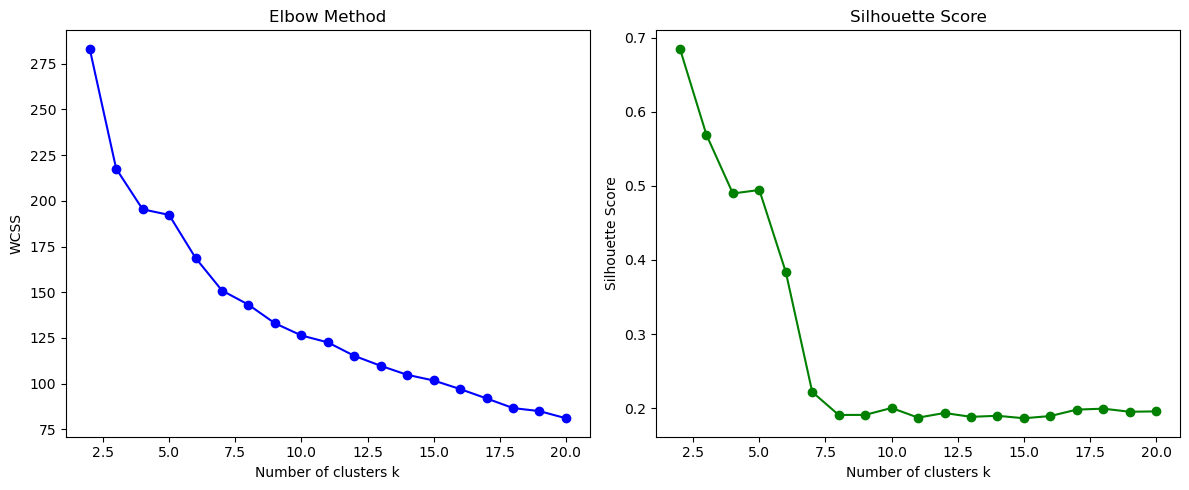

In [29]:
# Variant A final clusters (PAA) prima di decidere k
Ks, wcss, sil_scores = choose_k_elbow_silhouette(PAA_A, k_min=2, k_max=20)


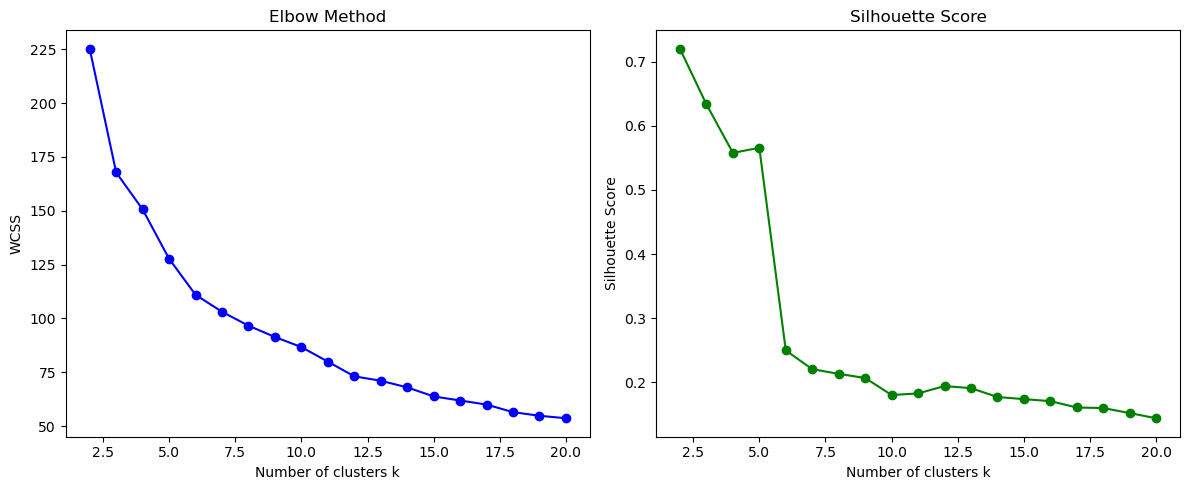

In [13]:
Ks_B, wcss_B, sil_scores_B = choose_k_elbow_silhouette(PAA_B, k_min=2, k_max=20)


In [30]:
import numpy as np

def describe_clusters(PAA, final_labels):
    clusters = np.unique(final_labels)
    seg_count = PAA.shape[1]

    for c in clusters:
        cluster_curves = PAA[final_labels == c]
        mean_curve = cluster_curves.mean(axis=0)
        peak_seg = np.argmax(mean_curve)
        start_val = mean_curve[0]
        end_val = mean_curve[-1]
        plateau = np.mean(mean_curve[seg_count//2:])  # valore medio della seconda metà

        description = ""
        if peak_seg == 0 and start_val > plateau:
            description = "Picco alto iniziale, poi calo rapido"
        elif peak_seg <= seg_count//3:
            description = "Picco moderato iniziale, decrescita lenta"
        elif peak_seg > seg_count//3:
            description = "Picco tardivo"
        elif np.allclose(mean_curve, mean_curve[0], atol=0.05):
            description = "Costante bassa"
        else:
            description = "Plateau medio-lungo"

        print(f"Cluster {c}: peak segment {peak_seg}, start={start_val:.2f}, end={end_val:.2f}, plateau={plateau:.2f}")
        print(f"   Descrizione: {description}\n")

# Esempio di utilizzo per Variant A
describe_clusters(PAA_A, finalA)

# E lo stesso può essere fatto per Variant B
describe_clusters(PAA_B, finalB)


Cluster 0: peak segment 0, start=1.66, end=-1.02, plateau=-0.63
   Descrizione: Picco alto iniziale, poi calo rapido

Cluster 1: peak segment 7, start=-1.35, end=-0.01, plateau=0.37
   Descrizione: Picco tardivo

Cluster 2: peak segment 2, start=0.18, end=-1.13, plateau=-0.59
   Descrizione: Picco moderato iniziale, decrescita lenta

Cluster 3: peak segment 0, start=1.52, end=-1.26, plateau=-0.72
   Descrizione: Picco alto iniziale, poi calo rapido

Cluster 4: peak segment 9, start=-0.82, end=0.59, plateau=0.63
   Descrizione: Picco tardivo

Cluster 5: peak segment 2, start=-1.23, end=-0.78, plateau=-0.20
   Descrizione: Picco moderato iniziale, decrescita lenta

Cluster 6: peak segment 5, start=-0.42, end=-0.96, plateau=-0.16
   Descrizione: Picco tardivo

Cluster 0: peak segment 0, start=1.51, end=-1.33, plateau=-0.68
   Descrizione: Picco alto iniziale, poi calo rapido

Cluster 1: peak segment 7, start=-1.32, end=-0.02, plateau=0.35
   Descrizione: Picco tardivo

Cluster 2: peak seg

Abbiamo applicato un approccio di clustering multi-livello sulle serie temporali dei box-office giornalieri dei film, combinando features automatiche (catch22) e interpretabili (picco, decay, tail share, PAA).

Dopo un micro-clustering iniziale con k=200, abbiamo rappresentato i micro-cluster con i medoid e ridotto la dimensionalità tramite PAA (12 segmenti). Il clustering finale è stato eseguito con k=5, scelto tramite l’Elbow Method e silhouette score.

La valutazione della purezza dei cluster rispetto alle etichette genre e rating_category mostra valori molto bassi di ARI e NMI:

Variant A (catch22): ARI≈0.003–0.006, NMI≈0.066–0.088

Variant B (catch22 + interpretabili): ARI≈0.005–0.013, NMI≈0.083–0.109

Questi risultati indicano che i cluster non corrispondono direttamente ai generi o alle categorie di rating, ma catturano pattern di forma delle serie temporali.

La visualizzazione delle curve medie dei cluster e le descrizioni automatiche mostrano tipologie di pattern come:

Picco iniziale alto seguito da rapido calo (blockbuster con forte opening)

Picco moderato e decrescita lenta (film con buona persistenza)

Picco tardivo o “slow-burn” (film che crescono col passaparola)

Plateau costante o basso (film di nicchia con performance regolare)

In sintesi, il clustering evidenzia dinamiche temporali dei box-office indipendentemente dalle etichette tradizionali, fornendo insight sui comportamenti tipici di incasso dei film.

A_DTW vs genre - ARI=0.002, NMI=0.072
A_DTW vs rating_cat - ARI=0.005, NMI=0.063
B_DTW vs genre - ARI=0.005, NMI=0.098
B_DTW vs rating_cat - ARI=0.017, NMI=0.085


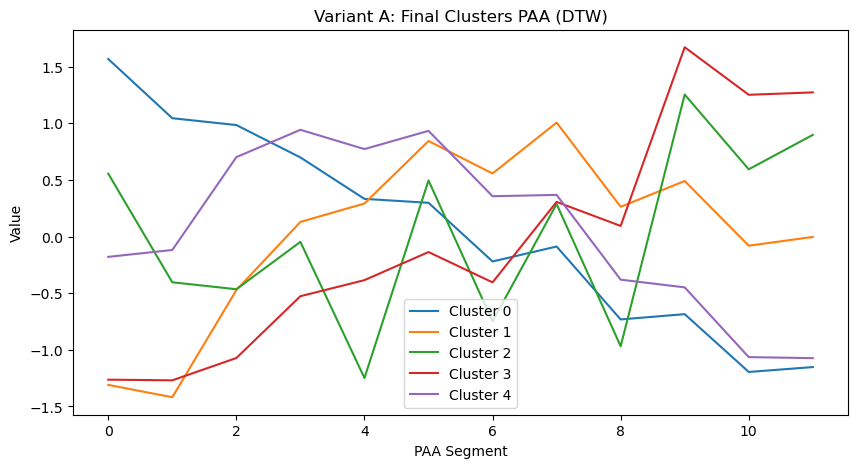

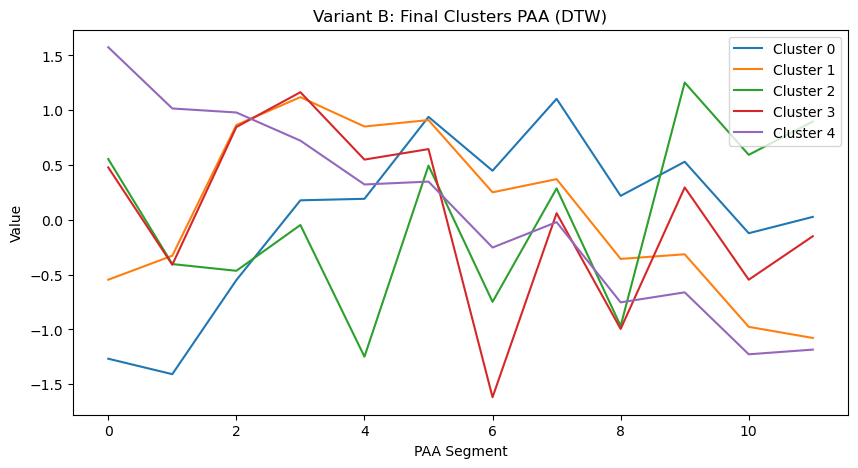

In [31]:
from tslearn.metrics import cdist_dtw
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# Calcola la matrice delle distanze DTW tra i medoid/PAA
D_A = cdist_dtw(PAA_A, PAA_A)  # Variante A
D_B = cdist_dtw(PAA_B, PAA_B)  # Variante B

# Clustering finale usando AgglomerativeClustering con distanza precomputed
k_final = 5  # puoi scegliere k in base a Elbow/Silhouette

finalA_dtw = AgglomerativeClustering(n_clusters=k_final, metric='precomputed', linkage='average').fit_predict(D_A)
finalB_dtw = AgglomerativeClustering(n_clusters=k_final, metric='precomputed', linkage='average').fit_predict(D_B)

# Propagare i cluster finali ai micro-cluster
final_labels_A_dtw = propagate_final_labels(microA, finalA_dtw, cluster_map_A)
final_labels_B_dtw = propagate_final_labels(microB, finalB_dtw, cluster_map_B)

# Valutazione
for name, labels in zip(["A_DTW", "B_DTW"], [final_labels_A_dtw, final_labels_B_dtw]):
    ari, nmi = evaluate(labels, meta, "genre")
    print(f"{name} vs genre - ARI={ari:.3f}, NMI={nmi:.3f}")
    ari, nmi = evaluate(labels, meta, "rating_category")
    print(f"{name} vs rating_cat - ARI={ari:.3f}, NMI={nmi:.3f}")

# Visualizzazione curve medie dei cluster
plot_paa_clusters(PAA_A, finalA_dtw, title="Variant A: Final Clusters PAA (DTW)")
plot_paa_clusters(PAA_B, finalB_dtw, title="Variant B: Final Clusters PAA (DTW)")


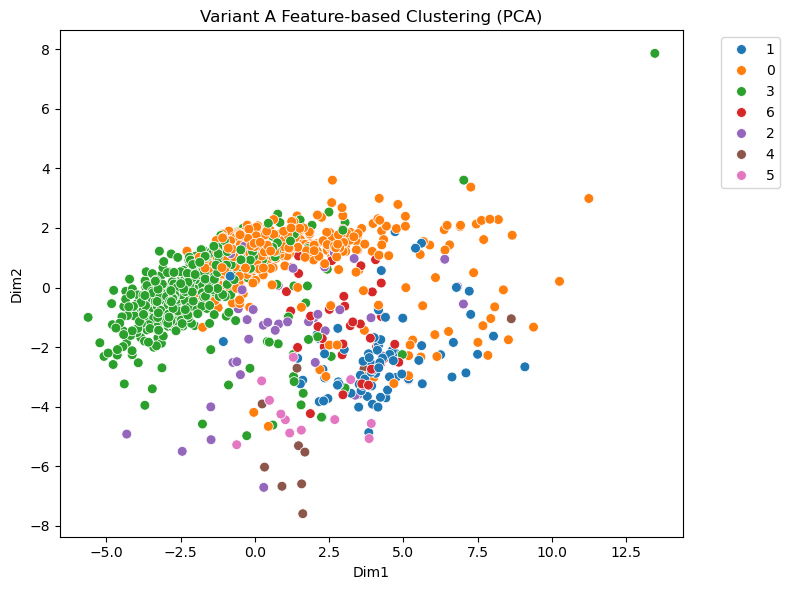

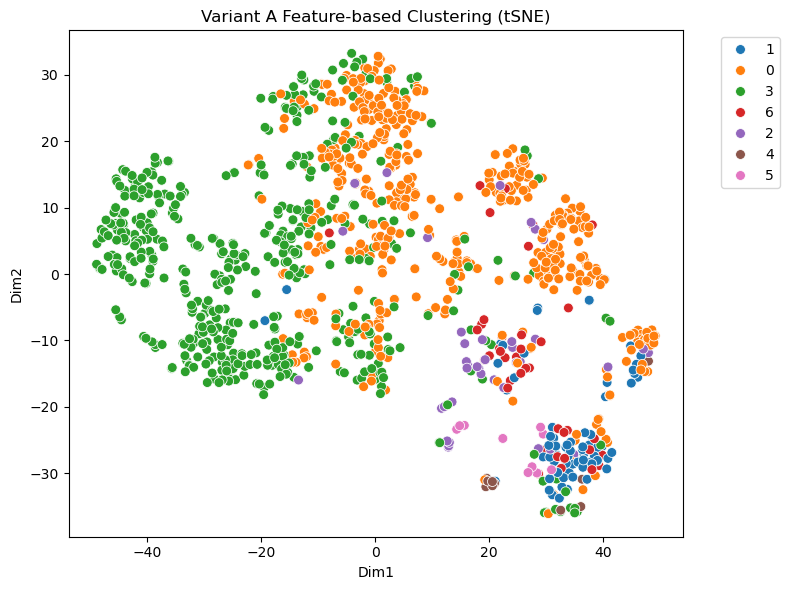

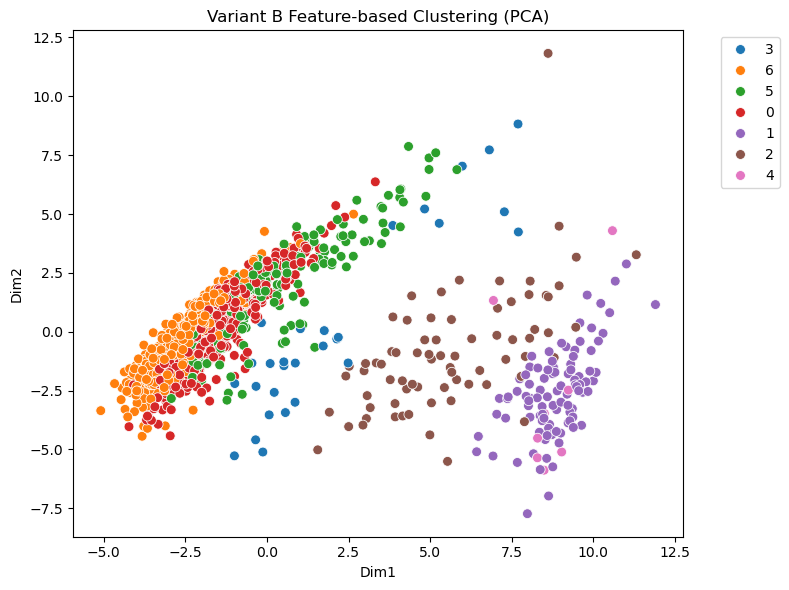

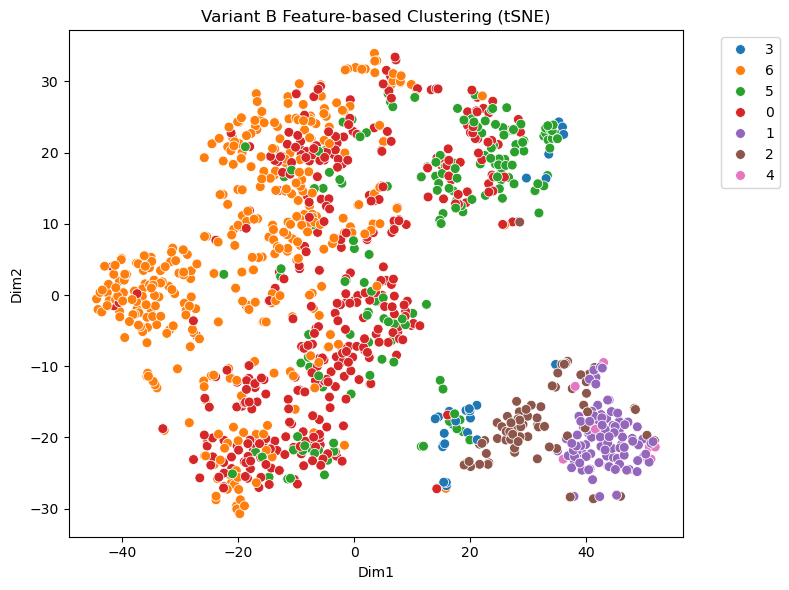

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_dim_reduction(features, labels, method="PCA", title="Feature-based Clustering"):
    """
    Plot dei cluster dopo riduzione dimensionale (PCA o t-SNE).
    
    features: array o dataframe di shape (n_samples, n_features)
    labels: array di cluster assegnati
    method: "PCA" o "tSNE"
    """
    # Standardizza tutte le features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    # Riduzione dimensionale
    if method=="PCA":
        reducer = PCA(n_components=2)
    elif method=="tSNE":
        reducer = TSNE(n_components=2, random_state=0, init='pca')
    else:
        raise ValueError("method must be 'PCA' or 'tSNE'")

    X_red = reducer.fit_transform(X_scaled)

    # Creazione dataframe per plotting
    df_plot = pd.DataFrame({
        "Dim1": X_red[:,0],
        "Dim2": X_red[:,1],
        "cluster": labels.astype(str)
    })

    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df_plot, x="Dim1", y="Dim2", hue="cluster", palette="tab10", s=50)
    plt.title(f"{title} ({method})")
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.xlabel("Dim1")
    plt.ylabel("Dim2")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Variant A (solo catch22)
# -----------------------------
plot_dim_reduction(featsA.values, final_labels_A, method="PCA", title="Variant A Feature-based Clustering")
plot_dim_reduction(featsA.values, final_labels_A, method="tSNE", title="Variant A Feature-based Clustering")

# -----------------------------
# Variant B (catch22 + interpretabili)
# -----------------------------
featsB_all = pd.concat([featsA, extract_features_interpretable(Y_z)], axis=1)
plot_dim_reduction(featsB_all.values, final_labels_B, method="PCA", title="Variant B Feature-based Clustering")
plot_dim_reduction(featsB_all.values, final_labels_B, method="tSNE", title="Variant B Feature-based Clustering")
